# Load Library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [130]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [77]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict_list = 
    {
            # 'correlation': 0,
            'subgroup_col_name': 'ST',
            # 'marginal_prior': 1,
            # 'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})"
) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][3:4]}

  2%|▏         | 1/51 [00:01<01:07,  1.36s/it]

before scaling: 505 392 1.288265306122449
after scaling: 392 392 1.0
before scaling: 496 125 3.968
after scaling: 125 125 1.0


  6%|▌         | 3/51 [00:03<01:03,  1.32s/it]

before scaling: 486 253 1.9209486166007905
after scaling: 253 253 1.0


 14%|█▎        | 7/51 [00:09<00:57,  1.30s/it]

before scaling: 466 219 2.127853881278539
after scaling: 219 219 1.0


 22%|██▏       | 11/51 [00:14<00:52,  1.31s/it]

before scaling: 447 336 1.3303571428571428
after scaling: 336 336 1.0


 24%|██▎       | 12/51 [00:15<00:50,  1.30s/it]

before scaling: 442 164 2.6951219512195124
after scaling: 164 164 1.0


 29%|██▉       | 15/51 [00:19<00:46,  1.30s/it]

before scaling: 427 314 1.3598726114649682
after scaling: 314 314 1.0


 31%|███▏      | 16/51 [00:20<00:45,  1.30s/it]

before scaling: 422 300 1.4066666666666667
after scaling: 300 300 1.0


 37%|███▋      | 19/51 [00:24<00:41,  1.31s/it]

before scaling: 594 566 1.0494699646643109
after scaling: 566 566 1.0
before scaling: 407 163 2.496932515337423
after scaling: 163 163 1.0


 47%|████▋     | 24/51 [00:31<00:35,  1.30s/it]

before scaling: 383 274 1.397810218978102
after scaling: 274 274 1.0


 51%|█████     | 26/51 [00:33<00:32,  1.29s/it]

before scaling: 628 469 1.3390191897654584
after scaling: 469 469 1.0
before scaling: 373 126 2.9603174603174605
after scaling: 126 126 1.0


 53%|█████▎    | 27/51 [00:35<00:30,  1.29s/it]

before scaling: 368 187 1.967914438502674
after scaling: 187 187 1.0


 57%|█████▋    | 29/51 [00:37<00:28,  1.29s/it]

before scaling: 358 294 1.217687074829932
after scaling: 294 294 1.0


 61%|██████    | 31/51 [00:40<00:26,  1.30s/it]

before scaling: 349 316 1.1044303797468353
after scaling: 316 316 1.0


 67%|██████▋   | 34/51 [00:44<00:22,  1.30s/it]

before scaling: 667 493 1.3529411764705883
after scaling: 492 493 0.9979716024340771
before scaling: 334 120 2.783333333333333
after scaling: 120 120 1.0


 76%|███████▋  | 39/51 [00:50<00:15,  1.29s/it]

before scaling: 309 260 1.1884615384615385
after scaling: 260 260 1.0


 80%|████████  | 41/51 [00:53<00:12,  1.30s/it]

before scaling: 701 357 1.9635854341736694
after scaling: 357 357 1.0
before scaling: 300 76 3.9473684210526314
after scaling: 76 76 1.0


 88%|████████▊ | 45/51 [00:58<00:07,  1.31s/it]

before scaling: 721 325 2.2184615384615385
after scaling: 325 325 1.0
before scaling: 280 101 2.772277227722772
after scaling: 101 101 1.0


 94%|█████████▍| 48/51 [01:02<00:03,  1.30s/it]

before scaling: 736 697 1.0559540889526542
after scaling: 697 697 1.0
before scaling: 265 171 1.5497076023391814
after scaling: 171 171 1.0


 98%|█████████▊| 50/51 [01:05<00:01,  1.30s/it]

before scaling: 746 326 2.2883435582822087
after scaling: 326 326 1.0
before scaling: 255 87 2.9310344827586206
after scaling: 87 87 1.0


100%|██████████| 51/51 [01:06<00:00,  1.30s/it]


[1000, 1000, 776, 252, 1000, 1000, 1000, 520, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 469, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 751, 1000, 371, 1000, 1000, 1000, 1000, 1000, 735, 1000, 710, 1000, 1000, 1000, 1000, 952, 400, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 715, 1000, 1000, 746, 337, 1000, 508, 1000, 1000, 1000, 821, 1000, 1000, 1000, 905, 1000, 1000, 1000, 1000, 738, 359, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 841, 1000, 1000, 509, 253, 1000, 1000, 1000, 1000, 1000, 1000, 450, 360, 1000, 1000, 1000, 1000, 947, 645, 1000, 1000, 436, 341]


In [105]:
class PortedMLPClassifier(nn.Module):
    def __init__(self, n_in_features=37, n_out_features=2):
        super(PortedMLPClassifier, self).__init__()
        layers = [
            nn.Linear(in_features=n_in_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=n_out_features),
            nn.Softmax(dim=1)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.layers(x)

    def get_feature_projection(self, x: torch.Tensor):
        return self.layers[:-2](x)
    
    def predict_proba(self, x: torch.Tensor):
        return self.forward(x)

def get_conf_scores(model, X_te, y_te):
    dataset = torch.utils.data.TensorDataset(torch.tensor(X_te.values).float(), torch.tensor(y_te).float())
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

    model.eval()
    y_pred = []
    y_true = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to('mps'), target.to('mps')
        output = model(data)
        y_pred.append(output.cpu().detach().numpy())
        y_true.append(target.cpu().detach().numpy())

    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return np.max(y_pred, axis=1)


In [96]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
# random.seed(seed)

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    target_models = []
    for i in range(1):
        model = PortedMLPClassifier(n_in_features=experiment.X_train.shape[1], n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
        dataset = torch.utils.data.TensorDataset(torch.tensor(experiment.X_train.values).float(), torch.tensor(experiment.y_tr_onehot).float())
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for epoch in tqdm(range(50)):
            for batch_idx, (data, target) in enumerate(train_loader):
                model.train()
                optimizer.zero_grad()
                data, target = data.to('mps'), target.to('mps')
                output = model(data)
                loss = nn.BCELoss()(output, target)

                loss.backward()
                optimizer.step()

        target_models.append(model)
    experiment.target_models = target_models

100%|██████████| 50/50 [05:25<00:00,  6.51s/it]


In [78]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Census19_subgroup_col_name_ST


In [5]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf_only_on_test = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummyy.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        base_model = model_utils.get_model(max_iter=500)
        experiment.clf_only_on_test = copy.deepcopy(base_model)
        experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf_only_on_test, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')

Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.1RPAREN


In [126]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.confidence_array = get_confidence_array(experiment, experiment.X_train, experiment.y_te, experiment.target_models[0], get_conf_fun=get_conf_scores)
    _, case_indices = CSMIA_attack(experiment.target_models[0], experiment.X_train, experiment.y_tr, experiment.ds.ds.meta, sensitive_columns=None)
    case_2_indices = case_indices[2]
    # experiment.sens_val = experiment.X_train[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel()[case_2_indices]
    # y_val = y_te.ravel()[case_2_indices]
    experiment.confidence_array = experiment.confidence_array[case_2_indices, :]
    experiment.X_case_2 = experiment.X_train.loc[case_2_indices].copy().reset_index(drop=True)
    experiment.y_case_2 = experiment.y_tr.ravel()[case_2_indices]

In [131]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.confidence_array = get_confidence_array(experiment, experiment.X_train, experiment.y_te, experiment.clf)
    _, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    case_2_indices = case_indices[2]
    # experiment.sens_val = experiment.X_train[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel()[case_2_indices]
    # y_val = y_te.ravel()[case_2_indices]
    experiment.confidence_array = experiment.confidence_array[case_2_indices, :]
    experiment.X_case_2 = experiment.X_train.loc[case_2_indices].copy().reset_index(drop=True)
    experiment.y_case_2 = experiment.y_tr.ravel()[case_2_indices]

In [113]:
st_50_indices = get_indices_by_group_condition(experiment.X_train, {'ST': 50})
get_angular_difference(experiment, experiment.confidence_array[st_50_indices], experiment.y_tr[st_50_indices])

-0.13085920483922803

In [112]:
st_0_indices = get_indices_by_group_condition(experiment.X_train, {'ST': 0})
get_angular_difference(experiment, experiment.confidence_array[st_0_indices], experiment.y_tr[st_0_indices])

0.017422069798339233

In [119]:
def get_slope(indices, conf_scores, conf_scores_flipped, y_val, sens_val, experiment):
    conf_scores, conf_scores_flipped, y_val, sens_val = conf_scores[indices], conf_scores_flipped[indices], y_val[indices], sens_val[indices]

    return [np.polyfit(np.concatenate([conf_scores[np.logical_and(y_val == 1, sens_val == 1)], conf_scores_flipped[np.logical_and(y_val == 1, sens_val == 0)]]), np.concatenate([conf_scores_flipped[np.logical_and(y_val == 1, sens_val == 1)], conf_scores[np.logical_and(y_val == 1, sens_val == 0)]]), 1)[0], np.polyfit(np.concatenate([conf_scores[np.logical_and(y_val == 0, sens_val == 1)], conf_scores_flipped[np.logical_and(y_val == 0, sens_val == 0)]]), np.concatenate([conf_scores_flipped[np.logical_and(y_val == 0, sens_val == 1)], conf_scores[np.logical_and(y_val == 0, sens_val == 0)]]), 1)[0]]

def get_angular_difference_old(indices, conf_scores, conf_scores_flipped, y_val, sens_val, experiment):
    slopes = get_slope(indices, conf_scores, conf_scores_flipped, y_val, sens_val, experiment)
    return np.arctan(np.abs(slopes[0] - slopes[1]) / (1 + slopes[0] * slopes[1])) * np.sign(slopes[0] - slopes[1])

In [123]:
def CSMIA_attack(model, X_test, y_test, meta, sensitive_columns=['marital_Married', 'marital_Single'], feature_dim_version=False):
    dfs = [X_test.copy() for _ in range(len(meta["sensitive_values"]))]
    if sensitive_columns is None:
        sensitive_columns = [f'{meta["sensitive_column"]}_{i}' for i in range(len(meta["sensitive_values"]))]
    for i in range(len(dfs)):
        dfs[i][sensitive_columns] = 0
        dfs[i][sensitive_columns[i]] = 1

        dfs[i] = torch.tensor(dfs[i].values).float().to('mps')
    
    y_confs = np.array([np.max(model.predict_proba(df).cpu().detach().numpy(), axis=1) for df in dfs]).T
    if feature_dim_version:
        y_confs = np.array([model.get_feature_projection(df).cpu().detach().numpy()[:,-1] for df in dfs]).T
    y_preds = [np.argmax(model.predict_proba(df).cpu().detach().numpy(), axis=1)==y_test.ravel() for df in dfs]
    y_preds = np.array(y_preds).T
    case_1_indices = (y_preds.sum(axis=1) == 1)
    case_2_indices = (y_preds.sum(axis=1) > 1)
    case_3_indices = (y_preds.sum(axis=1) == 0)

    eq_conf_indices = np.argwhere(y_confs[:, 0] == y_confs[:, 1]).ravel()
    # randomly add eps to one of the confidences for the records with equal confidences
    y_confs[eq_conf_indices, np.random.randint(0, 2, len(eq_conf_indices))] += 1e-6

    sens_pred = np.zeros(y_preds.shape[0])
    sens_pred[case_1_indices] = np.argmax(y_preds[case_1_indices], axis=1)
    sens_pred[case_2_indices] = np.argmax(y_confs[case_2_indices], axis=1)
    sens_pred[case_3_indices] = np.argmin(y_confs[case_3_indices], axis=1)
    if feature_dim_version:
        sens_pred[case_3_indices] = np.argmax(y_confs[case_3_indices], axis=1)
    return sens_pred, {1: case_1_indices, 2: case_2_indices, 3: case_3_indices}

In [ ]:
_, case_indices = CSMIA_attack(target_model, X_test, y_te, experiment.ds.ds.meta, sensitive_columns=None)
case_2_indices = case_indices[2]
sens_val = experiment.X_train[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel()[case_2_indices]
y_val = y_te.ravel()[case_2_indices]
conf_scores = experiment.confidence_array[case_2_indices, :]
experiment.X_case_2 = experiment.X_train.loc[case_2_indices].copy().reset_index(drop=True)
for i in range(50):
    condition = {'ST': i}
    fcondition = f'{condition}'
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    print(get_angular_difference_old(indices, conf_scores[:, 0], conf_scores_flipped, y_val, sens_val, experiment))

In [117]:
correlation_vs_ang_diff = {}
for i in range(50):
    condition = {'ST': i}
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    angular_difference = get_angular_difference(experiment, experiment.confidence_array[indices], experiment.y_tr[indices])
    correlation_vs_ang_diff[fcondition] = {}
    correlation_vs_ang_diff[fcondition]['correlation'] = correlation
    correlation_vs_ang_diff[fcondition]['angular_difference'] = angular_difference
    # print(calculate_stds(experiment, experiment.confidence_array[indices], experiment.y_tr[indices]))


<Axes: xlabel='correlation', ylabel='angular_difference'>

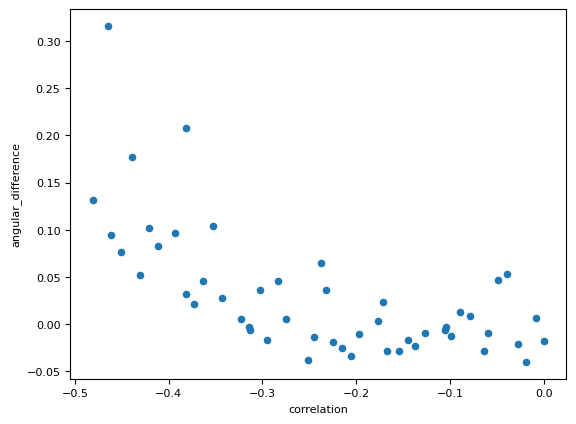

In [118]:
correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')
correlation_vs_ang_diff_df[['correlation', 'angular_difference']].plot(kind='scatter', x='correlation', y='angular_difference')

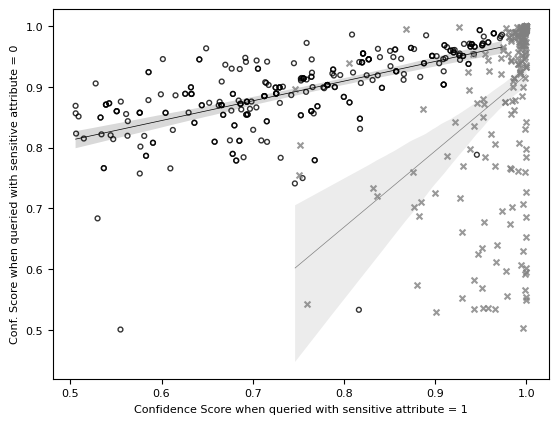

In [133]:
male_indices = get_indices_by_group_condition(experiment.X_case_2, {'ST': 50})
draw_confidence_array_scatter(experiment, experiment.confidence_array[male_indices],  experiment.y_case_2[male_indices], 1000)

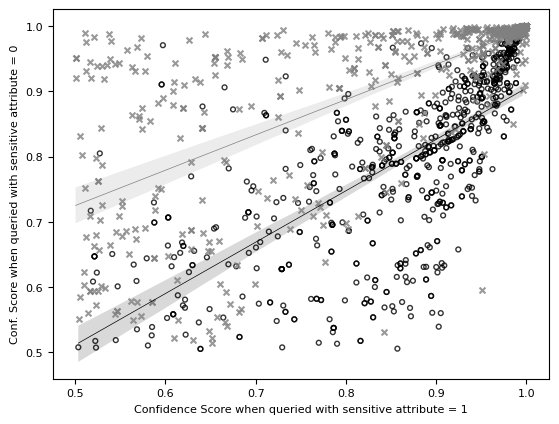

In [134]:
female_indices = get_indices_by_group_condition(experiment.X_case_2, {'ST': 0})
draw_confidence_array_scatter(experiment, experiment.confidence_array[female_indices],  experiment.y_case_2[female_indices], 1000)